In [8]:
# Auto-detect where your Google Drive "eye_project/processed/splits_strict_10cls_new" lives.

from pathlib import Path
import pandas as pd

candidates = [
    Path(r"G:\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\Google Drive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\GoogleDrive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path.home() / "Google Drive" / "My Drive" / "eye_project" / "processed" / "splits_strict_10cls_new",
]

FOUND = None
for p in candidates:
    if (p / "train.csv").exists() and (p / "val.csv").exists() and (p / "test.csv").exists():
        FOUND = p
        break

if FOUND is None:
    # Scan a few drives if the quick guesses failed
    for d in ["G","D","E","F","H","I"]:
        root = Path(f"{d}:/")
        if not root.exists(): continue
        try:
            for hit in root.rglob("eye_project/processed/splits_strict_10cls_new/train.csv"):
                folder = hit.parent
                if (folder/"val.csv").exists() and (folder/"test.csv").exists():
                    FOUND = folder
                    break
        except Exception:
            pass
        if FOUND is not None: break

if FOUND is None:
    raise FileNotFoundError("Could not locate splits_strict_10cls_new on this machine.")

print("✅ Found splits folder at:", FOUND)

train_df = pd.read_csv(FOUND / "train.csv")
val_df   = pd.read_csv(FOUND / "val.csv")
test_df  = pd.read_csv(FOUND / "test.csv")
print("Shapes:", train_df.shape, val_df.shape, test_df.shape)

SRC_ROOT = FOUND.parents[1]          # .../eye_project
SRC_RAW  = SRC_ROOT / "raw"
SRC_PROC = SRC_ROOT / "processed"
print("SRC_ROOT:", SRC_ROOT)


✅ Found splits folder at: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project\processed\splits_strict_10cls_new
Shapes: (768, 15) (165, 15) (165, 15)
SRC_ROOT: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project


In [9]:
# Copy referenced images to local SSD and write new local CSVs.

import os, shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm

DST_ROOT   = Path(r"C:\datasets\eye_project")  # local fast SSD
DST_RAW    = DST_ROOT / "raw"
DST_PROC   = DST_ROOT / "processed"
DST_SPLITS = DST_PROC / "splits_strict_10cls_new"

for p in [DST_ROOT, DST_RAW, DST_PROC, DST_SPLITS]:
    p.mkdir(parents=True, exist_ok=True)

# Normalize any lingering Colab paths -> Drive paths
def to_drive_prefix(p: str) -> str:
    return str(p).replace("/content/drive/MyDrive/eye_project", str(SRC_ROOT))

for df in (train_df, val_df, test_df):
    df["img_path"] = df["img_path"].astype(str).apply(to_drive_prefix)

# Unique existing image paths
all_paths = pd.concat([train_df["img_path"], val_df["img_path"], test_df["img_path"]]).unique().tolist()
all_paths = [p for p in all_paths if Path(p).exists()]
print(f"Total images to copy: {len(all_paths):,}")

def rel_under_raw(full_path: Path) -> Path:
    try:
        return full_path.relative_to(SRC_RAW)
    except Exception:
        parts = full_path.parts
        if "raw" in parts:
            i = parts.index("raw")
            return Path(*parts[i+1:])
        return Path(full_path.name)

copied, skipped = 0, 0
for s in tqdm(all_paths, desc="Copying images"):
    src = Path(s)
    rel = rel_under_raw(src)
    dst = DST_RAW / rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst); copied += 1
    else:
        skipped += 1

print(f"Images copied: {copied:,}  (already existed: {skipped:,})")

def to_local_prefix(p: str) -> str:
    return str(p).replace(str(SRC_ROOT), str(DST_ROOT))

def write_local(df: pd.DataFrame, name: str):
    out = df.copy()
    out["img_path"] = out["img_path"].astype(str).apply(to_local_prefix)
    out.to_csv(DST_SPLITS / name, index=False)

write_local(train_df, "train_local.csv")
write_local(val_df,   "val_local.csv")
write_local(test_df,  "test_local.csv")

print("✅ Local CSVs:", DST_SPLITS)


Total images to copy: 1,098


Copying images: 100%|██████████| 1098/1098 [36:23<00:00,  1.99s/it] 

Images copied: 1,098  (already existed: 0)
✅ Local CSVs: C:\datasets\eye_project\processed\splits_strict_10cls_new


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

ROOT_LOCAL = Path(r"C:\datasets\eye_project")
PROC_LOCAL = ROOT_LOCAL / "processed" / "splits_strict_10cls_new"

TRAIN_CSV = PROC_LOCAL / "train_local.csv"
VAL_CSV   = PROC_LOCAL / "val_local.csv"
TEST_CSV  = PROC_LOCAL / "test_local.csv"

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)
train_df.head(3)


Device: cuda
Train/Val/Test: (768, 15) (165, 15) (165, 15)


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_317,317,rfmid1_train,DN,0,0,0,0,0,0,0,0,0,1,C:\datasets\eye_project/raw/RFMiD/Training_Set...
1,rfmid2_train_625,625,rfmid2_train,DR,0,0,0,0,1,0,0,0,0,0,C:\datasets\eye_project/raw/RFMiD2_0/train/625...
2,rfmid1_test_16,16,NaN,ERM,0,0,0,0,0,0,1,0,0,0,C:\datasets\eye_project/raw/RFMiD/Test_Set/Tes...


In [11]:
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision import transforms
from PIL import Image
import torch

# VGG19 input: 224x224, ImageNet normalization
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        assert "img_path" in self.df.columns, "img_path missing"
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(CLASS_TO_IDX[row["label"]], dtype=torch.long)

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if len(batch) else (torch.empty(0), torch.empty(0, dtype=torch.long))

BATCH_SIZE = 32
PIN_MEMORY = torch.cuda.is_available()

train_ds = FundusDataset(train_df, transform_vgg)
val_ds   = FundusDataset(val_df,   transform_vgg)
test_ds  = FundusDataset(test_df,  transform_vgg)  # for later eval

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)

xb, yb = next(iter(train_dl))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # Expect (32, 3, 224, 224), (32,)


Batch shapes: (32, 3, 224, 224) (32,)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# VGG19 from timm with 10-class head
model = timm.create_model("vgg19", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("Model ready on:", DEVICE)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--timm--vgg19.tv_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model ready on: cuda


In [13]:
import time, json
from pathlib import Path

EPOCHS = 50
MODEL_DIR = ROOT_LOCAL / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
VGG19_BEST = MODEL_DIR / "vgg19_best.pth"
VGG19_HIST = MODEL_DIR / "vgg19_history.json"

def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    if train:
        for xb, yb in dl:
            if xb.nelement() == 0: continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_correct += (out.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0: continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                total_correct += (out.argmax(1) == yb).sum().item()
                total_samples += xb.size(0)

    return (total_loss / max(1, total_samples),
            total_correct / max(1, total_samples))

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time_sec": []}

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    ep_t0 = time.time()
    tr_loss, tr_acc = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc = run_epoch(model, val_dl,   optimizer, criterion, DEVICE, train=False)
    ep_time = time.time() - ep_t0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Epoch time: {ep_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), VGG19_BEST)

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f}")

with open(VGG19_HIST, "w") as f:
    json.dump(history, f, indent=2)

print("Saved best model  →", VGG19_BEST)
print("Saved history     →", VGG19_HIST)


Epoch 01/50 | Train Loss: 1.5420, Train Acc: 0.4805 | Val Loss: 1.1885, Val Acc: 0.6242 | Epoch time: 87.3s
Epoch 02/50 | Train Loss: 1.0504, Train Acc: 0.6484 | Val Loss: 1.1121, Val Acc: 0.6727 | Epoch time: 85.7s
Epoch 03/50 | Train Loss: 0.7421, Train Acc: 0.7630 | Val Loss: 1.0165, Val Acc: 0.6970 | Epoch time: 87.5s
Epoch 04/50 | Train Loss: 0.6983, Train Acc: 0.7852 | Val Loss: 0.9827, Val Acc: 0.7030 | Epoch time: 87.3s
Epoch 05/50 | Train Loss: 0.5840, Train Acc: 0.8112 | Val Loss: 0.9399, Val Acc: 0.7212 | Epoch time: 86.9s
Epoch 06/50 | Train Loss: 0.3560, Train Acc: 0.8932 | Val Loss: 1.2158, Val Acc: 0.6606 | Epoch time: 86.0s
Epoch 07/50 | Train Loss: 0.3094, Train Acc: 0.9102 | Val Loss: 1.3345, Val Acc: 0.7273 | Epoch time: 86.3s
Epoch 08/50 | Train Loss: 0.1493, Train Acc: 0.9531 | Val Loss: 1.4322, Val Acc: 0.7091 | Epoch time: 87.2s
Epoch 09/50 | Train Loss: 0.1852, Train Acc: 0.9466 | Val Loss: 1.2391, Val Acc: 0.7455 | Epoch time: 86.7s
Epoch 10/50 | Train Loss: 0.

C:\Users\admin\AppData\Local\Temp\ipykernel_30928\1668123307.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT_PATH, map_location=DEVICE)


✅ Loaded best VGG19: C:\datasets\eye_project\models\vgg19_best.pth

✅ Test Accuracy: 0.7758

=== Classification Report (per class) ===
              precision    recall  f1-score   support

        AION     0.0000    0.0000    0.0000         3
        ARMD     0.9000    0.8182    0.8571        11
        BRVO     0.8182    0.6000    0.6923        15
        CRVO     0.6667    0.7500    0.7059         8
          DR     0.8889    0.9014    0.8951        71
         MHL     0.0000    0.0000    0.0000         2
         ERM     0.0000    0.0000    0.0000         2
         ODC     0.7857    0.8462    0.8148        26
        RPEC     0.0000    0.0000    0.0000         3
          DN     0.5625    0.7500    0.6429        24

    accuracy                         0.7758       165
   macro avg     0.4622    0.4666    0.4608       165
weighted avg     0.7548    0.7758    0.7614       165



c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

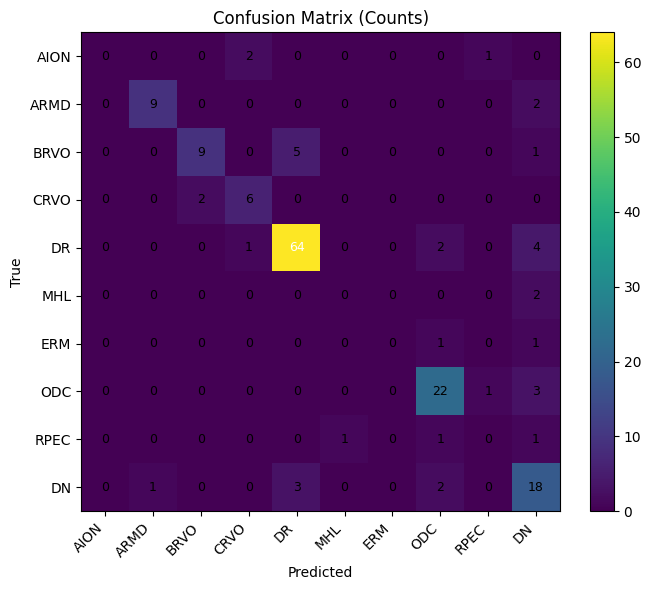


=== ROC–AUC ===
Micro-AUC: 0.9652 | Macro-AUC: 0.9311
AION: 0.9239
ARMD: 0.9965
BRVO: 0.8760
CRVO: 0.9697
DR: 0.9562
MHL: 0.9663
ERM: 0.9325
ODC: 0.9809
RPEC: 0.7737
DN: 0.9353


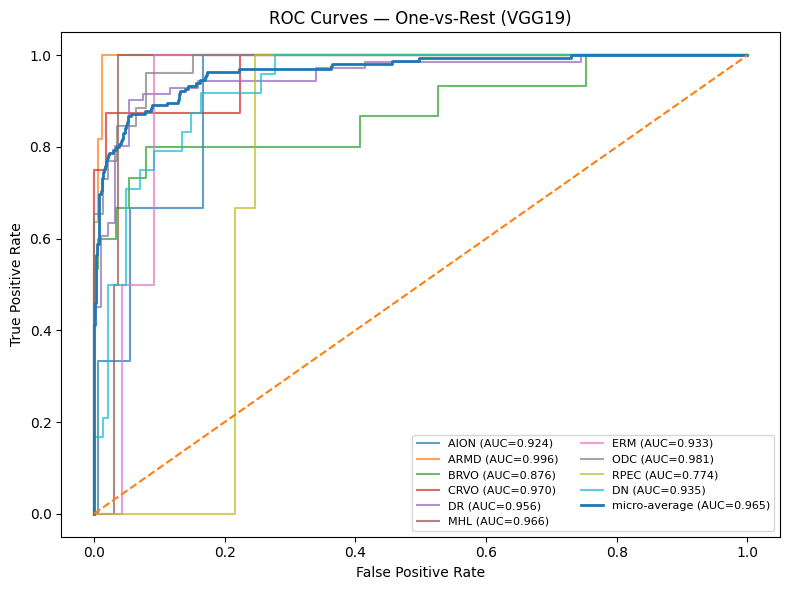

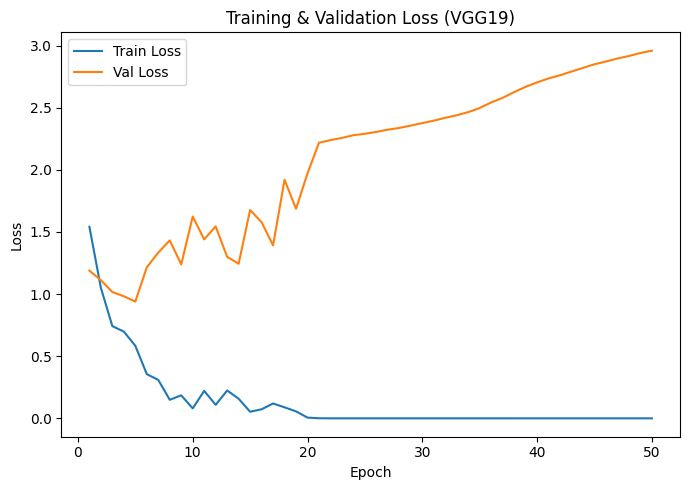

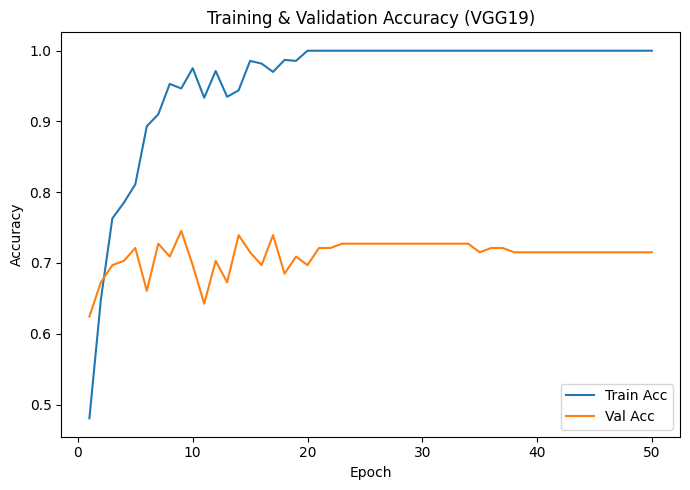

In [14]:
# ==== VGG19 — Test Evaluation (Confusion Matrix, Report, ROC–AUC, Curves) ====

import torch
import torch.nn.functional as F
import timm
import numpy as np
import json
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt

MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "vgg19_best.pth"
HIST_PATH = MODEL_DIR / "vgg19_history.json"

NUM_CLASSES = len(CLASSES)

# --- Rebuild VGG19 the same way you trained it (timm) and load weights ---
model = timm.create_model("vgg19", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()
print("✅ Loaded best VGG19:", CKPT_PATH)

# --- Inference on the test set ---
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        if xb.nelement() == 0:
            continue
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(yb.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# --- Overall Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# --- Classification Report ---
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# --- Confusion Matrix (with counts) ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_xticklabels(CLASSES, rotation=45, ha="right")
ax.set_yticklabels(CLASSES)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- ROC–AUC (one-vs-rest) ---
y_true_ovr = np.zeros((y_true.shape[0], NUM_CLASSES), dtype=int)
y_true_ovr[np.arange(y_true.shape[0]), y_true] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_ovr[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ovr.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(NUM_CLASSES)])

print("\n=== ROC–AUC ===")
print(f"Micro-AUC: {roc_auc['micro']:.4f} | Macro-AUC: {roc_auc['macro']:.4f}")
for i, cls in enumerate(CLASSES):
    print(f"{cls}: {roc_auc[i]:.4f}")

plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.3f})", alpha=0.7)
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (VGG19)")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# --- Training curves from history JSON ---
if HIST_PATH.exists():
    with open(HIST_PATH, "r") as f:
        hist = json.load(f)
    epochs = np.arange(1, len(hist["train_loss"])+1)

    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss (VGG19)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training & Validation Accuracy (VGG19)")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print(f"\n⚠️ History file not found at {HIST_PATH} — skipping curves.")


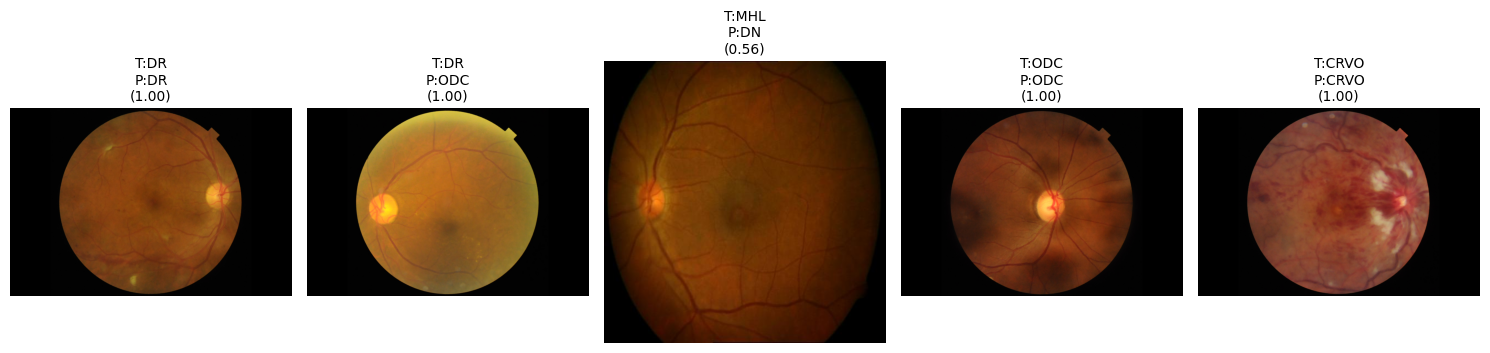

In [16]:
# ==== Inference Demo with VGG19 (Random Test Images) ====
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

# --- Define preprocessing (same as training) ---
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# --- Reload best VGG19 just in case ---
model = timm.create_model("vgg19", pretrained=False, num_classes=len(CLASSES)).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)  # safer load
model.load_state_dict(state)
model.eval()

# --- Prediction function ---
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = preproc(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    pred_idx = int(np.argmax(probs))
    return CLASSES[pred_idx], probs[pred_idx]

# --- Show 5 random test samples ---
samples = test_df.sample(5, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 8))
for i, row in samples.iterrows():
    img_path = row["img_path"]
    true_label = row["label"]

    pred_label, prob_top = predict_image(img_path)
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"T:{true_label}\nP:{pred_label}\n({prob_top:.2f})", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


✅ Saved per-image predictions → C:\datasets\eye_project\models\vgg19_test_predictions.csv
Misclassifications: 37 / 165


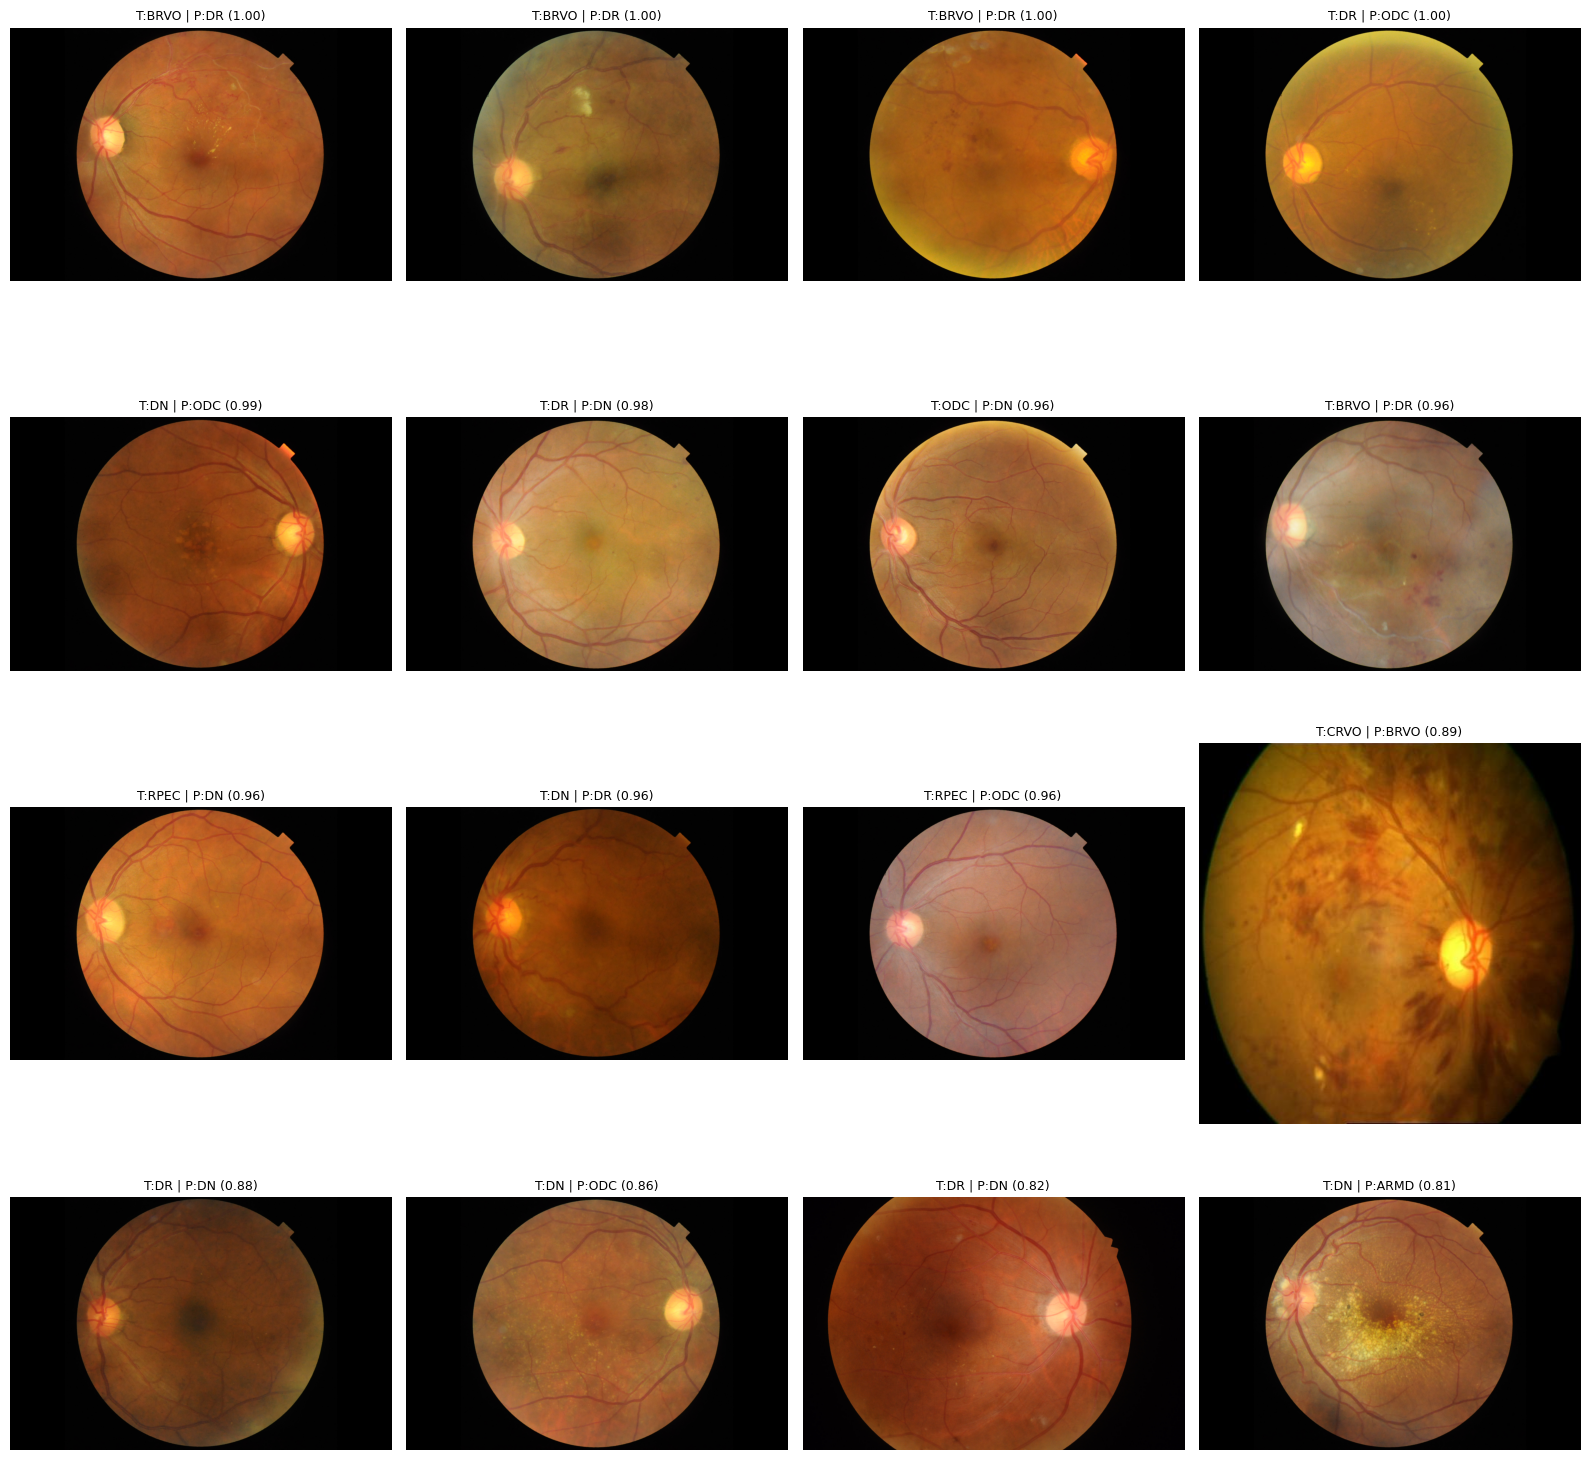

In [17]:
# ==== VGG19 — Show Misclassified Test Images (top confidence wrong) ====
import torch, numpy as np, pandas as pd
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import timm

# Paths & constants
MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "vgg19_best.pth"

# Preproc (same as training)
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Build VGG19 and load best weights
model = timm.create_model("vgg19", pretrained=False, num_classes=len(CLASSES)).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval()

# Predict helper
@torch.no_grad()
def predict_image(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = preproc(img).unsqueeze(0).to(DEVICE)
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    pred_idx = int(np.argmax(probs))
    return pred_idx, probs[pred_idx], probs  # index, confidence, full probs

# Run over entire test set (using test_df)
rows = []
for _, r in test_df.iterrows():
    pidx, pconf, probs = predict_image(r["img_path"])
    rows.append({
        "img_path": r["img_path"],
        "true_label": r["label"],
        "true_idx": CLASSES.index(r["label"]),
        "pred_label": CLASSES[pidx],
        "pred_idx": pidx,
        "pred_conf": float(pconf),
        **{f"prob_{c}": float(probs[i]) for i, c in enumerate(CLASSES)}
    })

pred_df_vgg = pd.DataFrame(rows)
pred_df_vgg["correct"] = (pred_df_vgg["true_idx"] == pred_df_vgg["pred_idx"]).astype(int)

out_csv = MODEL_DIR / "vgg19_test_predictions.csv"
pred_df_vgg.to_csv(out_csv, index=False)
print(f"✅ Saved per-image predictions → {out_csv}")
print(f"Misclassifications: {len(pred_df_vgg) - pred_df_vgg['correct'].sum()} / {len(pred_df_vgg)}")

# Show a grid of the most confident wrong predictions
mis = pred_df_vgg[pred_df_vgg["correct"] == 0].sort_values("pred_conf", ascending=False)
N = min(16, len(mis))
if N == 0:
    print("No misclassifications to display.")
else:
    samples = mis.head(N).reset_index(drop=True)
    cols = 4
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i, row in samples.iterrows():
        img = Image.open(row["img_path"]).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"T:{row['true_label']} | P:{row['pred_label']} ({row['pred_conf']:.2f})", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Using device: cpu
Explaining (FAST): C:\datasets\eye_project\raw\RFMiD\Training_Set\Training\253.png  (pred DR @ 1.00)


100%|██████████| 400/400 [00:54<00:00,  7.33it/s]


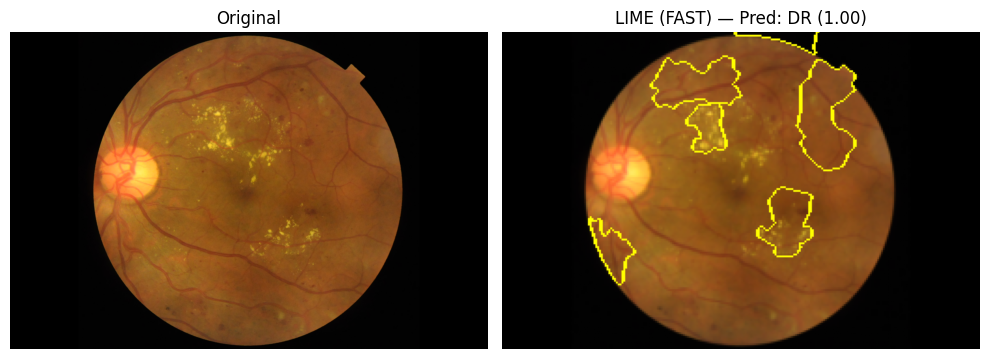

Saved: C:\datasets\eye_project\models\reports\vgg19_lime_fast\253_lime_fast_DR.png


In [3]:
# === LIME Fast Mode for VGG19 (side-by-side, CPU/GPU auto) ===
import sys, subprocess, numpy as np, pandas as pd, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# deps (install if missing)
try:
    import lime
    from lime import lime_image
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
    from lime import lime_image

try:
    from skimage.segmentation import slic
    from skimage.transform import resize
    from skimage.segmentation import mark_boundaries
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-image"])
    from skimage.segmentation import slic, mark_boundaries
    from skimage.transform import resize

import timm

# ---- Paths / constants (edit only if your paths differ) ----
ROOT       = Path(r"C:\datasets\eye_project")
MODEL_PATH = ROOT / "models" / "vgg19_best.pth"
TEST_CSV   = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR    = ROOT / "models" / "reports" / "vgg19_lime_fast"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---- Model (no internet) ----
model = timm.create_model("vgg19", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval()

# ---- Preprocessing (must match training) ----
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

@torch.no_grad()
def predict_proba_np(imgs_np: np.ndarray) -> np.ndarray:
    """
    imgs_np: (N,H,W,3) in [0,1] floats (LIME passes this)
    returns: (N,C) softmax
    """
    xs = []
    for arr in imgs_np:
        pil = Image.fromarray((arr * 255).astype(np.uint8))
        xs.append(preproc(pil))
    xb = torch.stack(xs, 0).to(DEVICE)          # (N,3,224,224)
    logits = model(xb)
    return F.softmax(logits, dim=1).detach().cpu().numpy()

# ---- Fast SLIC segmentation function ----
def seg_fn_slic(img_hwc_float01, n_segments=140, compactness=10, sigma=1):
    # img: (H,W,3) float[0,1]
    return slic(img_hwc_float01, n_segments=n_segments, compactness=compactness,
                sigma=sigma, start_label=0)

# ---- LIME explain (FAST) ----
def lime_explain_fast(img_path: str,
                      num_samples: int = 400,     # 300–500 fast; 800–1200 nicer but slower
                      num_features: int = 10,     # superpixels to display
                      downscale: int = 256,       # resize for LIME (speeds up a lot)
                      n_segments: int = 140,      # fewer segments → faster
                      compactness: int = 10,
                      positive_only: bool = True):
    img_path = str(Path(img_path))
    pil_full = Image.open(img_path).convert("RGB")
    img_disp = np.array(pil_full)                           # for plotting

    # Downscale for LIME perturbations/segmentation (model still sees 224)
    if max(img_disp.shape[:2]) > downscale:
        ratio = downscale / max(img_disp.shape[:2])
        new_h = int(img_disp.shape[0] * ratio)
        new_w = int(img_disp.shape[1] * ratio)
        img_small = (resize(img_disp, (new_h, new_w, 3), anti_aliasing=True,
                             preserve_range=True) / 255.0).astype(np.float32)
    else:
        img_small = (img_disp / 255.0).astype(np.float32)

    explainer = lime_image.LimeImageExplainer(random_state=42)

    explanation = explainer.explain_instance(
        img_small,                                  # (h,w,3) float01 (downscaled)
        classifier_fn=predict_proba_np,
        top_labels=3,
        hide_color=None,
        num_samples=num_samples,
        segmentation_fn=lambda x: seg_fn_slic(x, n_segments=n_segments, compactness=compactness, sigma=1)
    )

    # explain model's predicted label
    probs = predict_proba_np(img_small[None, ...])[0]
    pred_idx = int(np.argmax(probs))
    pred_lbl = CLASSES[pred_idx]; pred_conf = float(probs[pred_idx])

    temp, mask = explanation.get_image_and_mask(
        label=pred_idx,
        positive_only=positive_only,
        num_features=num_features,
        hide_rest=False
    )

    # Plot & save
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img_disp); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(mark_boundaries((temp*255).astype(np.uint8), mask))
    ax[1].set_title(f"LIME (FAST) — Pred: {pred_lbl} ({pred_conf:.2f})"); ax[1].axis("off")
    plt.tight_layout()
    out_path = OUT_DIR / f"{Path(img_path).stem}_lime_fast_{pred_lbl}.png"
    plt.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)
    return pred_lbl, pred_conf, out_path

# ---- Pick a confident test image & run LIME FAST ----
test_df = pd.read_csv(TEST_CSV)
test_df["img_path"] = test_df["img_path"].apply(lambda p: str(Path(p)))

best_path, best_conf, best_lbl = None, -1.0, None
for _, r in test_df.sample(min(60, len(test_df)), random_state=13).iterrows():
    pil = Image.open(r["img_path"]).convert("RGB")
    x = preproc(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pr = F.softmax(model(x), dim=1)[0].detach().cpu().numpy()
    c = int(np.argmax(pr))
    if pr[c] > best_conf:
        best_conf, best_path, best_lbl = pr[c], r["img_path"], CLASSES[c]

print(f"Explaining (FAST): {best_path}  (pred {best_lbl} @ {best_conf:.2f})")
_ = lime_explain_fast(best_path,
                      num_samples=400,
                      num_features=10,
                      downscale=256,
                      n_segments=140,
                      compactness=10,
                      positive_only=True)


Explaining: C:\datasets\eye_project\raw\RFMiD2_0\train\346.jpg


100%|██████████| 400/400 [00:58<00:00,  6.89it/s]


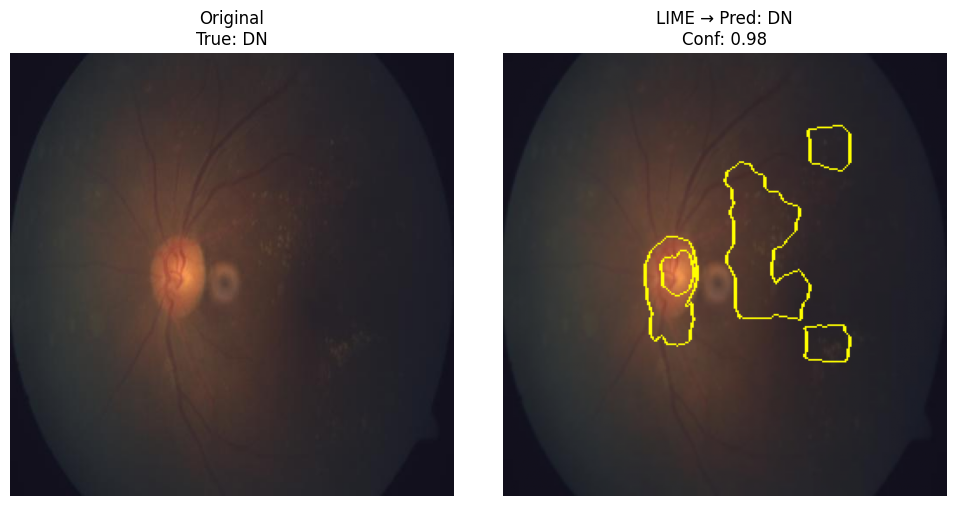

Explaining: C:\datasets\eye_project\raw\RFMiD\Evaluation_Set\Validation\295.png


100%|██████████| 400/400 [00:50<00:00,  7.90it/s]


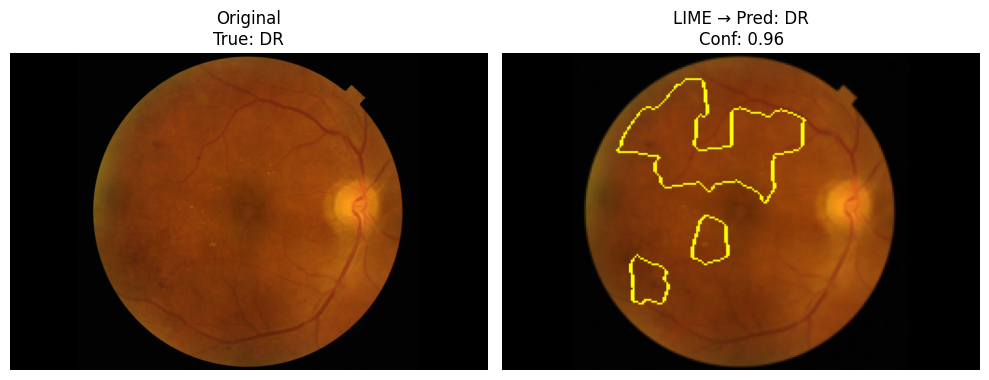

Explaining: C:\datasets\eye_project\raw\RFMiD\Evaluation_Set\Validation\281.png


100%|██████████| 400/400 [00:50<00:00,  7.85it/s]


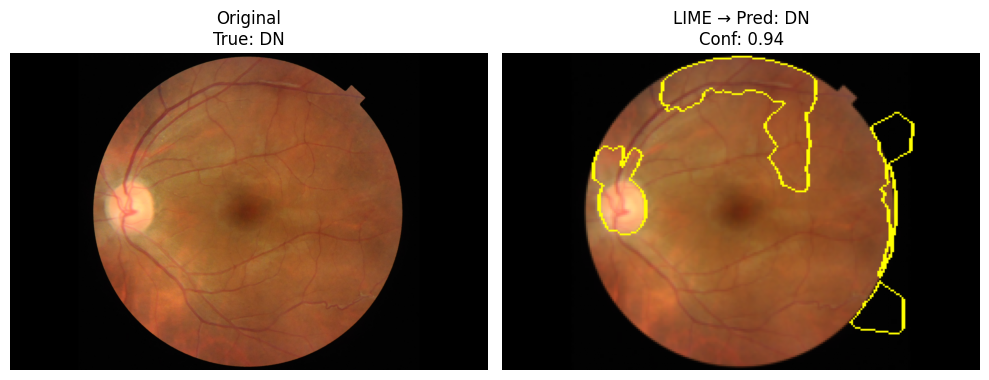

In [4]:
# === Multi-sample LIME visualization with labels ===
def lime_explain_and_plot(img_path, true_label=None,
                          num_samples=400, num_features=10,
                          downscale=256, n_segments=140,
                          compactness=10, positive_only=True):

    pil_full = Image.open(img_path).convert("RGB")
    img_disp = np.array(pil_full)

    # downscale for LIME
    if max(img_disp.shape[:2]) > downscale:
        ratio = downscale / max(img_disp.shape[:2])
        new_h = int(img_disp.shape[0] * ratio)
        new_w = int(img_disp.shape[1] * ratio)
        from skimage.transform import resize
        img_small = (resize(img_disp, (new_h, new_w, 3), anti_aliasing=True,
                             preserve_range=True) / 255.0).astype(np.float32)
    else:
        img_small = (img_disp / 255.0).astype(np.float32)

    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(
        img_small,
        classifier_fn=predict_proba_np,
        top_labels=3,
        hide_color=None,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=n_segments, compactness=compactness,
                                       sigma=1, start_label=0)
    )

    probs = predict_proba_np(img_small[None, ...])[0]
    pred_idx = int(np.argmax(probs))
    pred_lbl = CLASSES[pred_idx]; pred_conf = float(probs[pred_idx])

    temp, mask = explanation.get_image_and_mask(
        label=pred_idx,
        positive_only=positive_only,
        num_features=num_features,
        hide_rest=False
    )

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img_disp); ax[0].axis("off")
    ax[0].set_title(f"Original\nTrue: {true_label if true_label else '?'}")

    from skimage.segmentation import mark_boundaries
    ax[1].imshow(mark_boundaries((temp*255).astype(np.uint8), mask))
    ax[1].axis("off")
    ax[1].set_title(f"LIME → Pred: {pred_lbl}\nConf: {pred_conf:.2f}")

    plt.tight_layout()
    plt.show()

    return pred_lbl, pred_conf


# === Pick N random test images and run ===
N = 3  # how many to show
subset = test_df.sample(N, random_state=99)

for _, r in subset.iterrows():
    img_path = r["img_path"]
    true_lbl = r["label"] if "label" in r else "?"
    print(f"Explaining: {img_path}")
    _ = lime_explain_and_plot(img_path, true_label=true_lbl,
                              num_samples=400, num_features=10,
                              downscale=256, n_segments=140, compactness=10)
